In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

%matplotlib inline


### Reading Data

In [4]:
url = 'https://raw.githubusercontent.com/Colin-Riley/monitoring/main/checkout_sales_last_hour__big_query__2022-02-22T19_45_09.595349Z.csv'

checkout_sales = pd.read_csv(url)
checkout_sales

,time,avg_last_30days,avg_last_7days,same_day_last_week,yesterday,today
0,00h,13.60,14.4,16.0,9.0,14.0
1,01h,4.90,5.2,2.0,4.0,6.0
2,02h,2.75,2.0,3.0,1.0,2.0
3,03h,1.15,0.6,1.0,1.0,NaN
4,04h,1.20,1.4,1.0,NaN,NaN
5,05h,0.80,1.0,NaN,NaN,1.0
6,06h,3.80,3.4,2.0,2.0,13.0
7,07h,13.25,13.2,15.0,10.0,10.0
8,08h,28.55,29.2,41.0,25.0,33.0
9,09h,46.00,48.0,45.0,49.0,50.0


### Filling NaN values

In [5]:
checkout_sales = checkout_sales.fillna(0)

### Setting helper DF

In [6]:
range = pd.DataFrame(checkout_sales['time'])
range['std'] = checkout_sales.std(axis=1)
range['mean'] = checkout_sales.mean(axis=1)
range

/tmp/ipykernel_22588/1394122733.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  range['std'] = checkout_sales.std(axis=1)
/tmp/ipykernel_22588/1394122733.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  range['mean'] = checkout_sales.mean(axis=1)


,time,std,mean
0,00h,2.622975,13.40
1,01h,1.530359,4.42
2,02h,0.782624,2.15
3,03h,0.466369,0.75
4,04h,0.672309,0.72
5,05h,0.517687,0.56
6,06h,4.633357,4.84
7,07h,2.212578,12.29
8,08h,6.095695,31.35
9,09h,2.073644,47.60


### Getting z-scores from query

In [7]:
pysqldf = lambda q: sqldf(q, globals())
query = ('''
SELECT cs.time, (today - mean) / std AS "z-score" 
FROM checkout_sales AS cs 
JOIN range ON cs.time = range.time
''')
z_scores = pysqldf(query)
z_scores.set_index('time', inplace=True)
z_scores

,z-score
time,
00h,0.228748
01h,1.032437
02h,-0.191663
03h,-1.608169
04h,-1.070935
05h,0.849934
06h,1.761142
07h,-1.034992
08h,0.270683


### Plotting possible anomalies

<AxesSubplot: xlabel='time'>

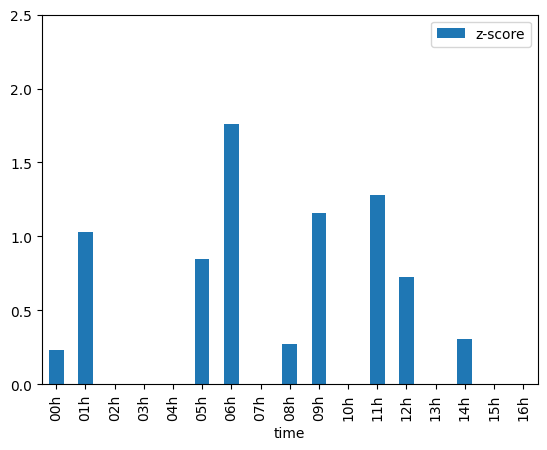

In [8]:
z_scores.plot(kind='bar', ylim=[0, 2.5])

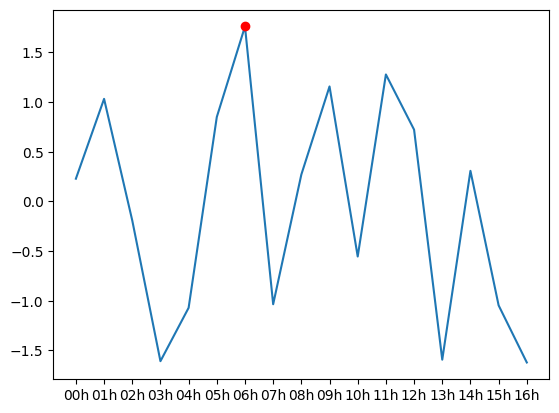

In [9]:
plt.plot(z_scores)
anomalies = z_scores[z_scores['z-score'] > 1.5]
plt.plot(anomalies, 'or')